## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [2]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

## 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [3]:
# Read raw data in lunyu_20chapters.txt

### YOUR CODE HERE ###
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)
### END YOUR CODE ###

Total vocabulary: 1352


In [49]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    word_ids = [corpus.word2id[word] for word in words] # 把word转换成id

    for i,central_word_id in enumerate(word_ids):
        # 窗格的范围
        start=max(0,i-window_size)
        end=min(len(word_ids),i+window_size+1)# 在下面的循环中，这个不含

        outside_word_ids=[word_ids[j] for j in range(start,end) if i!=j]
        
        for outside_word_id in outside_word_ids:
            negative_samples=corpus.getNegatives(target=central_word_id,size=k)
            # 生成训练数据，格式为(center_word, outside_word, negative_samples)
            yield(central_word_id,outside_word_id,negative_samples)
    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        ### YOUR CODE HERE ###
        center=[]
        outside=[]
        negative=[]

        for center_word,outside_word,neg_samples in batch:
            center.append(center_word)
            outside.append(outside_word)
            negative.append(neg_samples)

        
        centers, outsides, negatives = zip(*batch)
        center = torch.tensor(centers, dtype=torch.long)
        outside = torch.tensor(outsides, dtype=torch.long)
        negatives = torch.stack([torch.tensor(n, dtype=torch.long) for n in negatives])
        yield center, outside, negatives
        ### END YOUR CODE ###

## 2. Define the Model

In [50]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        ### YOUR CODE HERE ###
        positive_score=torch.sum(v_c*u_o,dim=1)
        positive_score=torch.clamp(positive_score,min=-10,max=10)
        postive_loss=-F.logsigmoid(positive_score)

        negative_score = torch.bmm(v_c.unsqueeze(1), u_n.transpose(1, 2)).squeeze(1)
        negative_score=torch.clamp(negative_score,min=-10,max=10)
        negative_loss=-F.logsigmoid(-negative_score).sum(dim=1)
        loss = postive_loss+negative_loss
        # Hint: torch.clamp the input to F.logsigmoid to avoid numerical underflow/overflow
        ### END YOUR CODE ###

        return loss
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

## 3. Train and Evaluate

In [60]:
def train(model, optimizer, scheduler, data, batch_size, epochs, device, corpus):
    # Write your own code f or this train function
    # You don't need exactly the same arguments

    ### YOUR CODE HERE ###
    model.train()
    model.to(device)

    for epoch in range(epochs):
        total_loss=0.0
        num_batches=0

        for center,outside,negative in batchify(data,batch_size):
            center=center.to(device)
            outside=outside.to(device)
            negative=negative.to(device)


            loss=model(center,outside,negative).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss+=loss.item()
            num_batches+=1

            if num_batches % 20 == 0:
                lr = scheduler.get_last_lr()[0] 
                print(f"Epoch {epoch} Batch {num_batches} - Loss: {loss.item():.4f}, Learning Rate: {lr:.6f}")
                
        scheduler.step()
        print(f"Epoch {epoch} - Average Loss: {total_loss/(num_batches):.4f}")


    ### END YOUR CODE ###


# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_size = 50
window_size = 5
k = 10 # the number of negative samples, change with your own choice for better embedding performance
min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function
vocab_size=corpus.vocab_size


# Initialize the corpus and model
corpus = CorpusReader('lunyu_20chapters.txt', min_count)
vocab_size = corpus.vocab_size
model = SkipGram(vocab_size, emb_size).to(device)

# 优化器和调度器
optimizer = torch.optim.SparseAdam(model.parameters(),lr=initial_lr) # or torch.optim.SparseAdam()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10,eta_min=0.001) # or torch.optim.lr_scheduler.StepLR()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

words = list(corpus.word2id.keys())
data = list(generate_data(words, window_size, k, corpus))
data = [(torch.tensor(c, device=device), torch.tensor(o, device=device), torch.tensor(n, device=device)) for c, o, n in data]  # 统一到 device 

train(model, optimizer, scheduler, data, batch_size, 15, device, corpus)

### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done
### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done

Total vocabulary: 1352


/var/folders/82/wch4p99157d31_2xqn8213gr0000gn/T/ipykernel_55999/35357338.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negatives = torch.stack([torch.tensor(n, dtype=torch.long) for n in negatives])


Epoch 0 Batch 20 - Loss: 7.6162, Learning Rate: 0.025000
Epoch 0 Batch 40 - Loss: 7.6153, Learning Rate: 0.025000
Epoch 0 Batch 60 - Loss: 7.5805, Learning Rate: 0.025000
Epoch 0 Batch 80 - Loss: 7.5188, Learning Rate: 0.025000
Epoch 0 Batch 100 - Loss: 7.6158, Learning Rate: 0.025000
Epoch 0 Batch 120 - Loss: 7.3306, Learning Rate: 0.025000
Epoch 0 Batch 140 - Loss: 7.2375, Learning Rate: 0.025000
Epoch 0 Batch 160 - Loss: 7.5118, Learning Rate: 0.025000
Epoch 0 Batch 180 - Loss: 7.3757, Learning Rate: 0.025000
Epoch 0 Batch 200 - Loss: 7.7005, Learning Rate: 0.025000
Epoch 0 Batch 220 - Loss: 7.5691, Learning Rate: 0.025000
Epoch 0 Batch 240 - Loss: 7.3714, Learning Rate: 0.025000
Epoch 0 Batch 260 - Loss: 7.3901, Learning Rate: 0.025000
Epoch 0 Batch 280 - Loss: 7.8044, Learning Rate: 0.025000
Epoch 0 Batch 300 - Loss: 7.3731, Learning Rate: 0.025000
Epoch 0 Batch 320 - Loss: 7.3536, Learning Rate: 0.025000
Epoch 0 Batch 340 - Loss: 7.3866, Learning Rate: 0.025000
Epoch 0 Batch 360 

In [62]:
import time
#  Run training with different hyper-parameters.
def run_with_hyperparameters(emb_size,k,window_size):
    model=SkipGram(vocab_size,emb_size)

    initial_lr = 0.025
    optimizer = torch.optim.SparseAdam(model.parameters(),lr=initial_lr) # or torch.optim.SparseAdam()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10,eta_min=0.001) # or torch.optim.lr_scheduler.StepLR()

    words=list(corpus.word2id.keys())
    data=list(generate_data(words,window_size,k,corpus))
    dataloader=batchify(data,batch_size)   

    start=time.time()
    train(model, optimizer, scheduler, data, batch_size, 15, device, corpus)
    end=time.time()
    training_time=end-start

    embedding_file = f"embeddings_emb{emb_size}_k{k}_ws{window_size}.txt"
    model.save_embedding(corpus.id2word, embedding_file)
    print(f"emb_size={emb_size}, k={k}, window_size={window_size}: training time={training_time:.2f} seconds")
    

emb_sizes=[50,100]
ks=[2,5]
window_sizes=[1,3]

for emb_size in emb_sizes:
    for k in ks:
        for window_size in window_sizes:
            run_with_hyperparameters(emb_size,k,window_size)

Epoch 0 Batch 20 - Loss: 2.0796, Learning Rate: 0.025000
Epoch 0 Batch 40 - Loss: 2.0779, Learning Rate: 0.025000
Epoch 0 Batch 60 - Loss: 2.0802, Learning Rate: 0.025000
Epoch 0 Batch 80 - Loss: 2.0838, Learning Rate: 0.025000
Epoch 0 Batch 100 - Loss: 2.0779, Learning Rate: 0.025000
Epoch 0 Batch 120 - Loss: 2.0793, Learning Rate: 0.025000
Epoch 0 Batch 140 - Loss: 2.0766, Learning Rate: 0.025000
Epoch 0 Batch 160 - Loss: 2.0867, Learning Rate: 0.025000
Epoch 0 - Average Loss: 2.0793
Epoch 1 Batch 20 - Loss: 1.9832, Learning Rate: 0.024413
Epoch 1 Batch 40 - Loss: 1.9600, Learning Rate: 0.024413
Epoch 1 Batch 60 - Loss: 1.9118, Learning Rate: 0.024413
Epoch 1 Batch 80 - Loss: 1.8231, Learning Rate: 0.024413
Epoch 1 Batch 100 - Loss: 1.8572, Learning Rate: 0.024413
Epoch 1 Batch 120 - Loss: 1.8336, Learning Rate: 0.024413
Epoch 1 Batch 140 - Loss: 1.7446, Learning Rate: 0.024413
Epoch 1 Batch 160 - Loss: 1.6821, Learning Rate: 0.024413
Epoch 1 - Average Loss: 1.8348
Epoch 2 Batch 20 -

## 4. Save the Embeddings


Save the embeddings into a `gensim` compatible format.

In [ ]:
output_file = 'embeddings.txt'

weights = model.emb_v.detech().cpu().data.numpy()
with open(output_file, "w") as f:
    f.write(f"{vocab_size} {emb_size}\n")  # First line: vocab size and vector dimension
    for idx, vector in enumerate(weights):
        vector_str = " ".join(map(str, vector))
        f.write(f"{model.id2word[idx]} {vector_str}\n") 

## 5. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [64]:
from gensim.models import KeyedVectors

def load_embedding(file_path):
    gensim_model = KeyedVectors.load_word2vec_format(file_path,binary=False)
    
    embeddings = gensim_model.vectors  # NumPy 数组，形状为 (词汇量, 嵌入维度)
    
    word2id = {word: idx for idx, word in enumerate(gensim_model.index_to_key)}
    
    return embeddings, word2id

In [ ]:
def plot_embeddings(embeddings, word2id, selected_words, title):
    plt.rcParams['font.sans-serif'] = ['Songti SC']
    selected_indices = [word2id[word] for word in selected_words if word in word2id]
    selected_embeddings = embeddings[selected_indices]

    svd = TruncatedSVD(n_components=2)
    reduced_embeddings = svd.fit_transform(selected_embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue')
    for i, word in enumerate(selected_words):
        if word in word2id:
            plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=12)

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()


/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


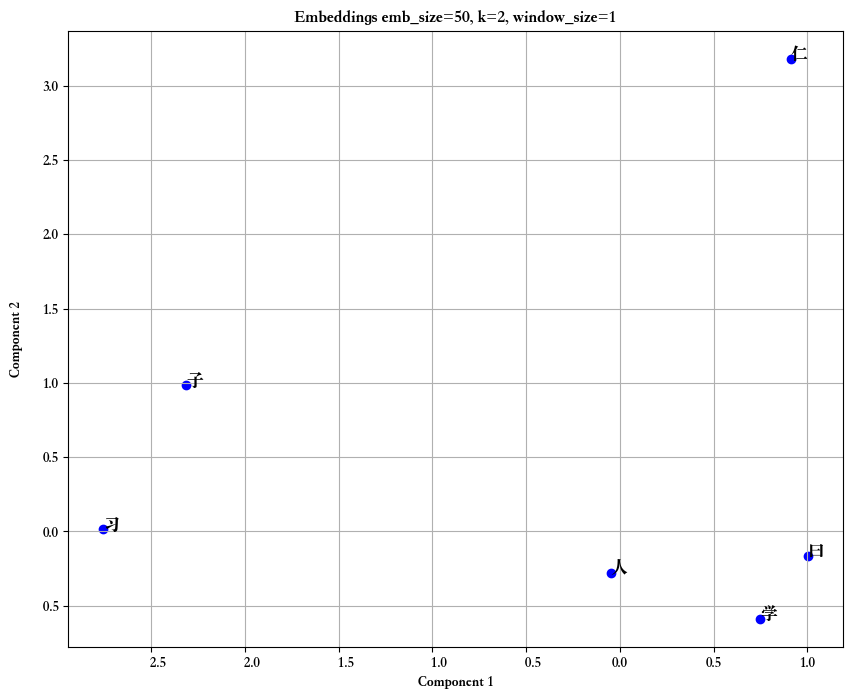

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


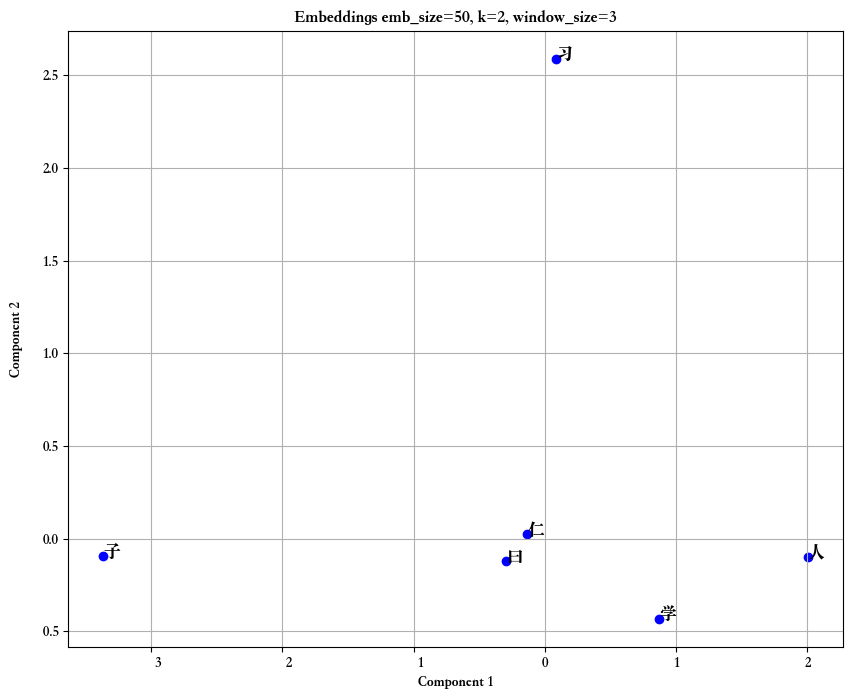

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


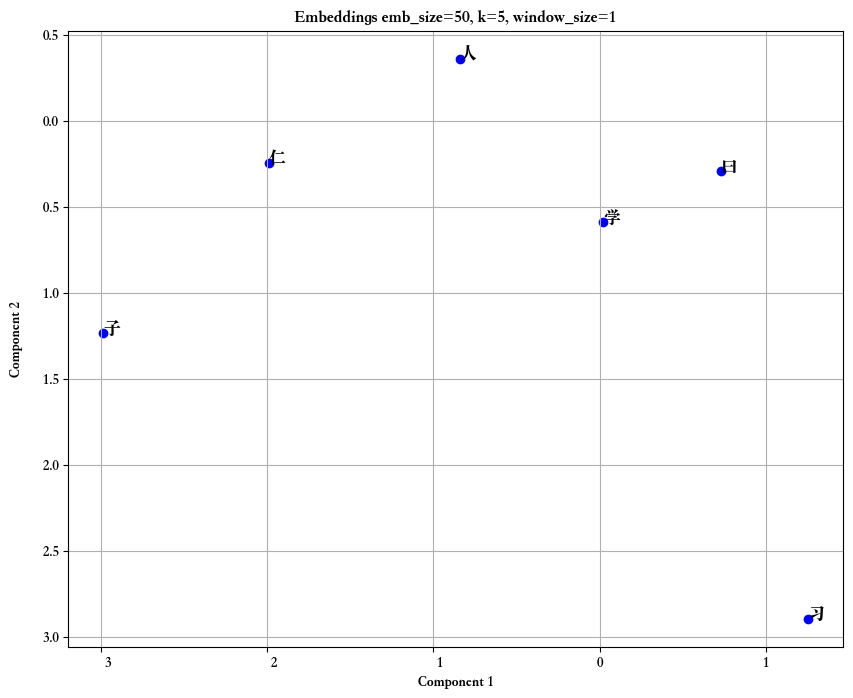

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


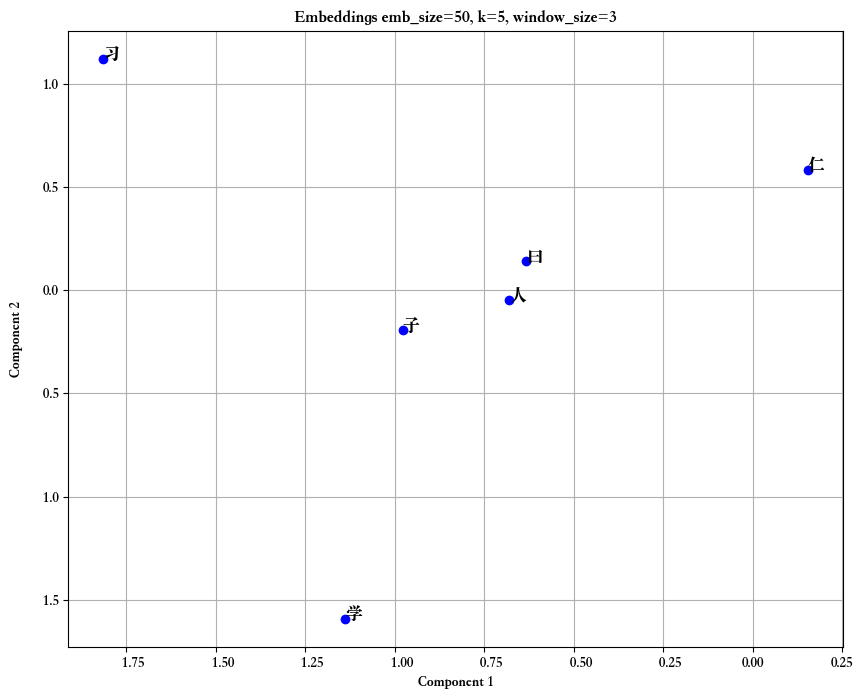

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


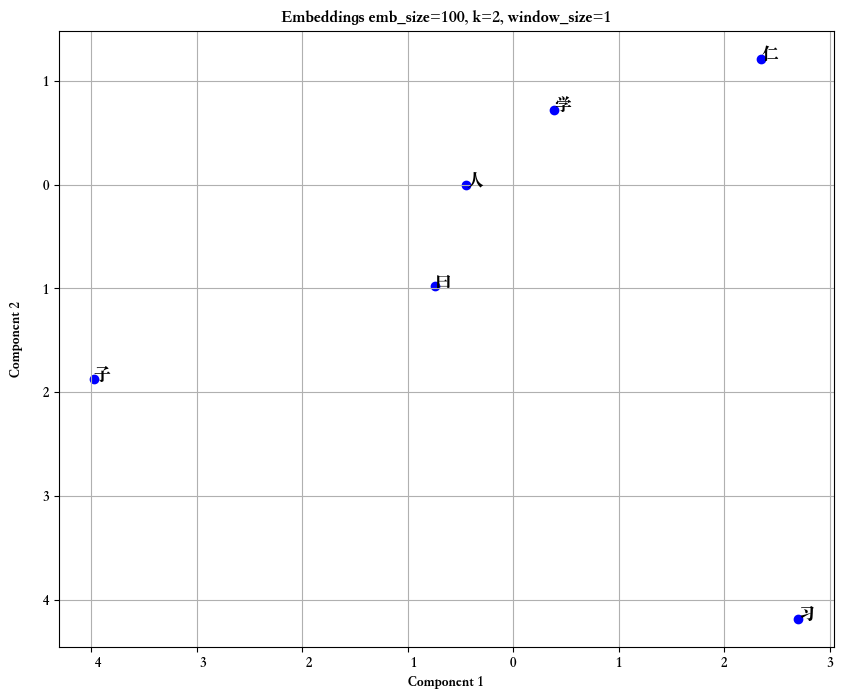

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


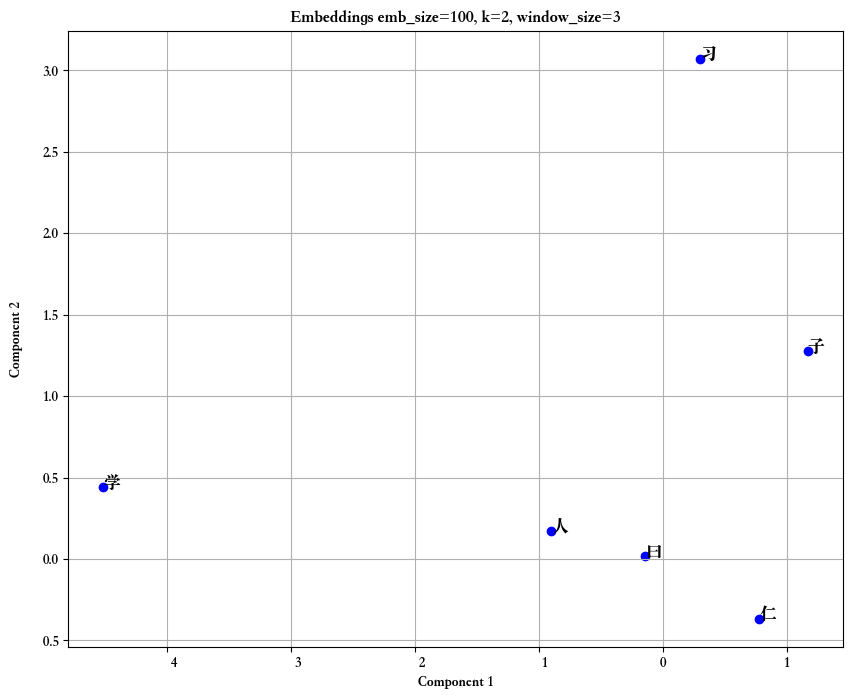

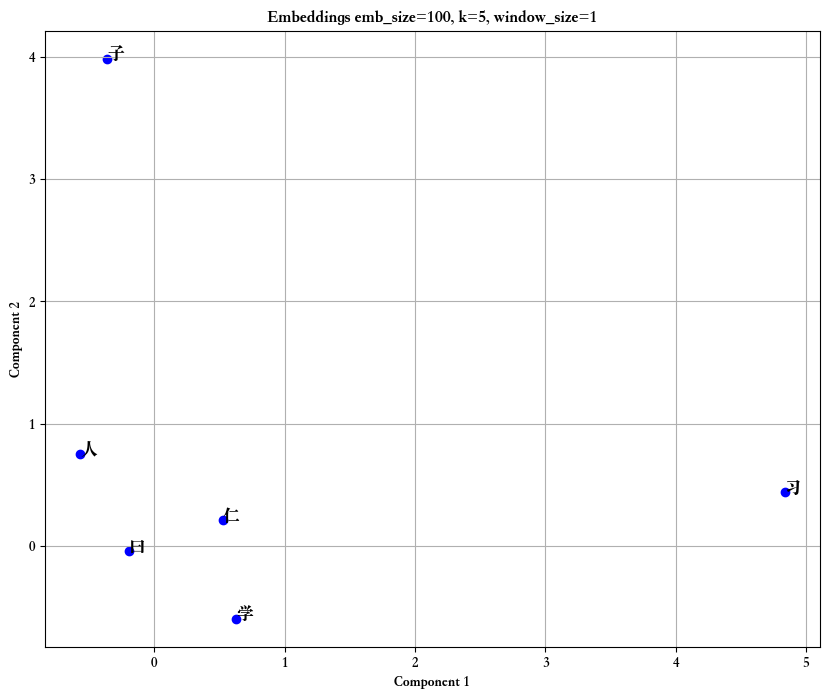

/opt/anaconda3/envs/NLP/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Songti SC.
  fig.canvas.print_figure(bytes_io, **kw)


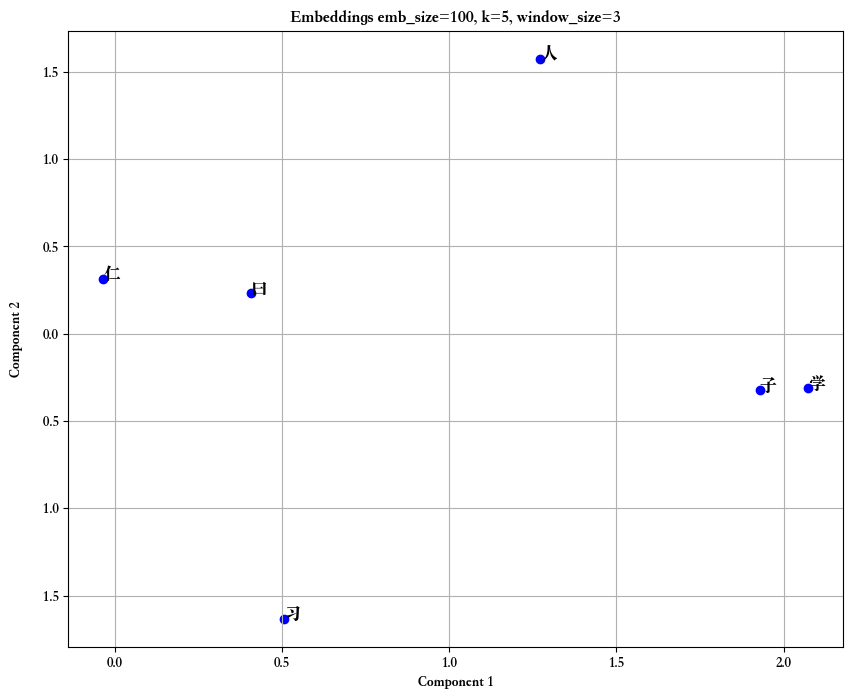

Embeddings saved to embeddings_saved.txt


In [70]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

emb_sizes=[50,100]
ks=[2,5]
window_sizes=[1,3]

for emb_size in emb_sizes:
    for k in ks:
        for window_size in window_sizes:
            embedding_file = f"embeddings_emb{emb_size}_k{k}_ws{window_size}.txt"
            embeddings, word2id = load_embedding(embedding_file)

            plot_embeddings(embeddings, word2id, words, f"Embeddings emb_size={emb_size}, k={k}, window_size={window_size}")

# 循环结束后保存最后一组
embedding_file_to_save = "embeddings_saved.txt"
with open(embedding_file_to_save, 'w', encoding='utf-8') as f:
    f.write(f"{len(words)} {len(embeddings[0])}\n") 
    for word, embedding in zip(words, embeddings):
        f.write(f"{word} {' '.join(map(str, embedding))}\n")
print(f"Embeddings saved to {embedding_file_to_save}")
            